# Data preprocessing

Here we preprocess the data, loading the image files and saving them to disk them as numpy arrays.

We can specify the folder structure of how we save the files, which images we import for training and testing, and what type of preprocessing we choose to do on the images.

In [ ]:
from basic_preprocessing import DataPreprocessor

### Specify which folders to read from when loading training and testing data

Each training image must be placed in a folder whose name is the label for the image. For example, a Type 1 image called `1.jpg` must have a path ending in `"/Type_1/1.jpg"`.

The testing images, on the other hand, have no labels and should thus be located all together in a folder.

 - `training_folders` should be a list of folder-names we get images from, i.e. a list of strings.
 - `testing_folder` should be a single folder, i.e. a string.

In [ ]:
# ===================== USER INPUT =====================
training_folders = ["./Data/train"] #+ ["./Data/Type_1", "./Data/Type_2", "./Data/Type_3"]
testing_folder = "./Data/test"
# ======================================================

### Create a preprocessing object and test whether it reads the images correctly

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
preproc = DataPreprocessor(training_folders=training_folders, testing_folder=testing_folder)
preproc.test_loading()

### Find a good image resizing

The input images are large, typically several thousands of pixels on each axis. We want to resize them to as small as possible, while allowing a human to look at the image and still be able to tell which Type it is.

Here we can play with the variable `resize_shape` to choose one that does not wash out important information in the images.

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
preproc.test_resizing(resize_shape=(150, 150, 3), index_image=17)

### Specify parameters for preprocessing

 - `data_folder` is the folder in which we save the preprocessed numpy arrays, needed for TensorFlow training.
 - `training_subfolder` is the subfolder inside `data_folder` which contains the training numpy arrays (and their labels).
 - `testing_subfolder` is the subfolder inside `data_folder` which contains the testing numpy arrays (as well as a little auxiliary information about the arrays: which image each row corresponds to, and what order the Type 1, Type 2 and Type 3 appear in the one-hot-encoded labels).
 - `optimal_resize_shape` is the best resizing shape chosen above.
 - There are a lot of training images. We thus preprocess them in batches. `batch_size` controls the number of images in each batch. Note that if some images cannot be preprocessed, some batches will contain fewer than `batch_size` images.
 - Preprocessing can take some time. `parallelize` controls whether we want to parallelize this job over all local cores.

In [ ]:
# ===================== USER INPUT =====================
data_folder = "./TensorFlow_data"
training_subfolder = "/training_data"
testing_subfolder = "/testing_data"
optimal_resize_shape = (150, 150, 3)
batch_size = 2**8
parallelize = True
# ======================================================

### Execute the preprocessing

*N.B. The preprocessing only gets recomputed if it is unable to detect the correct number of files in the expected folders. Therefore, if you change `optimal_resize_shape` and leave all other variables intact, the preprocessing will not happen! If you want to make sure all the numpy arrays get recomptued, you should delete the folders containing the numpy-array data.*

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
preproc.preprocess_save(data_folder=data_folder,
                        training_subfolder=training_subfolder,
                        testing_subfolder=testing_subfolder,
                        resize_shape=optimal_resize_shape, batch_size=batch_size,
                        parallelize=parallelize)

# Benchmark Model

Since what determines the type of cancer is closely related to the colors seen in the images (bright red if often indicative of Type 1 whereas all white is indicative of Type 3), as a benchmark model we'll perform a random forest precisely on the average-pixel RGB of each image.

In [ ]:
from benchmark_model import BenchmarkModel

We create the BenchmarkModel object

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
benchmdl = BenchmarkModel()

### Training

We will now train the model. In order to do this, we need to specify:

 - `totnumbatches` is not strictly speaking an input for training, just a convenience variable which counts the total number of training that we have.
 - `training_batches` is a list speciying the set of batches we use for training, i.e. each element of `training_batches` is an integer.
 - `leftright` is a boolean specifying whether we also train on images that have bee flipped left-to-right.
 - `updown` is a boolean specifying whether we also train on images that have bee flipped upside-down.
 - `agnosticic_average` lets us average the predicted probabilities with the agnostic probabilities (which assign equal probability to all categories). `agnosticic_average` is an int which specifies how many times we average with the agnostic probability.
 
The validation set can be specified in one of two ways. Either we can specify a batch number to be validation set, or we can feed it a specific array of our choice.

 - `validation_batch` is the integer specifying which validation batch we use for validation.
 - Alternatively, we can specify `validation_inputarray` as the input array (with shape `(number of data points, size of x-axis, size of y-axis, number of color channels)`). We then also need to specify the validation labels with `validation_labels` (which should have shape `(number of data points, number of output channels)`).
 
***N.B. It's important you ONLY set `validation_batch`, or ONLY set `validation_inputarray` and `validation_labels`!***

In [ ]:
# ===================== USER INPUT =====================
totnumbatches = benchmdl.count_training_batches("./TensorFlow_data/training_data")
training_batches = range(1, totnumbatches)
leftright = True
updown = True
agnosticic_average = 3

validation_batch = 0
validation_inputarray = []
validation_labels = []
#benchmdl.model_name = "random_forest"
# ======================================================

Now perform the training on a random forest.

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
(benchmark_accuracy,
 benchmark_train_loss,
 benchmark_val_loss) = benchmdl.train(training_batches=training_batches,
                                      leftright=leftright, updown=updown,
                                      validation_inputarray=validation_inputarray,
                                      validation_labels=validation_labels,
                                      validation_batchnum=validation_batch,
                                      agnosticic_average=agnosticic_average)
print("Accuracy: {}\nTraining loss: {}\nValidation loss: {}".format(benchmark_accuracy,
                                                                    benchmark_train_loss,
                                                                    benchmark_val_loss))

The loss for a completely agnostic probability would be 1.0986. Hence, we see that we do slightly better than random, but barely.

### Make predictions on test set¶

We may now use the trained model to make a prediction on the test set.

 - `load_test_set` is the full path to the numpy data file which contains the test-set data.
 - Alternatively, the test set can be specified with the variable `test_set`.
 - `save_prob_location` is the full path to the folder in which we want to save the predicted probabilities. These may be useful for later.

In [ ]:
# ===================== USER INPUT =====================
load_test_set = "./TensorFlow_data/testing_data/testing_images.npy"
test_set = []
save_prob_location = "./BenchmarkProbabilities"
# ======================================================

We now make a prediction on the test set and save the predicted probabilities in the folder specified by `save_prob_location`.

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
from modules.path_munging import create_folder
import numpy as np

create_folder(save_prob_location)
benchmdl_probabilities = benchmdl.test(load_test_set=load_test_set, test_set=test_set,
                              agnosticic_average=agnosticic_average)
np.save(save_prob_location + "/benchmarkprobs.npy", benchmdl_probabilities)

# Neural Network

We construct a variety of neural networks and study their behavior to the amount and quality of the data.

In [1]:
from convnet import ConvNet

## LetNet-like networks

We will first study simple LeNet-like convolutional neural networks, which consist of a couple of convolutional layers (with max pooling) followed by a few fully-connected layers.

After constructing a simple network, we'll begin by checking how the validation performance of the network is affected by the quantitity of training data, to determine whether the network needs to be more complex or whether we need to increase the amount of data we train on.

### Specify parameters

We will train on a network with a specific architecture. To speed up training, we will train with a larger learning rate, and fine-tune our training with a smaller learning rate.

 - `input_shape` is the dimension-shape of the input image arrays.
 - `output_channels` is the number of output categories (i.e. cervix Types).
 - `convolutional_layers` specifies the parameters for the convolutional + max pooling layers. Each layer has the form  
 ```[int (number of output channels),  
    tuple of length 2 (size of conv filter),  
    tuple of length 2 (step size of conv filter),  
    tuple of length 2 (size of max pooling filter),  
    tuple of length 2 (step size max pooling filter)]```
 - `connected_layers` specifies the parameters for the fully connected layers. It is a list where each element is the number of neurons in the layer.
 - `keep_prob` is the dropout keep_prob (usually recommended to be 0.5).
 - `learning_rate`is the learning rate. We can change this later if needed.
 - `model_name` is the model's name, used when saving and loading trained models.

In [2]:
# ===================== USER INPUT =====================
input_shape = (150, 150, 3)
output_channels = 3
convolutional_layers = [[10, (4, 4), (1, 1), (2, 2), (2, 2)],
                        [20, (4, 4), (1, 1), (2, 2), (2, 2)],
                        [30, (4, 4), (1, 1), (2, 2), (2, 2)]]
connected_layers = [100, 30]
keep_prob = 0.5
learning_rate = 0.001 # standard value is 0.001
model_name = "lenet_3x2" # This name means we have 3 convolutional layers and 2 fully connected layers
# ======================================================

Now we initialize the network with the properties specified above.

In [3]:
# ============ DOES NOT REQUIRE USER INPUT =============
simple_network = ConvNet(input_shape=input_shape,
                         output_channels=output_channels, 
                         convolutional_layers=convolutional_layers,
                         connected_layers=connected_layers, 
                         keep_prob=keep_prob,
                         learning_rate=learning_rate,
                         model_name=model_name)

## Training

We will now train the neural network. We begin by specifying the parameters for training.

 - `data_folder` is the folder in which we save the preprocessed numpy arrays, needed for TensorFlow training.
 - `training_subfolder` is the subfolder inside `data_folder` which contains the training numpy arrays (and their labels).
 - `testing_subfolder` is the subfolder inside `data_folder` which contains the testing numpy arrays (as well as a little auxiliary information about the arrays: which image each row corresponds to, and what order the Type 1, Type 2 and Type 3 appear in the one-hot-encoded labels).
 - `size_of_minibatch` is the size of each training-step minibatch, i.e. the number of input images in each traininig step

The validation set can be specified in one of two ways. Either we can specify a batch number to be validation set, or we can feed it a specific array of our choice.

 - `validation_batch` is the integer specifying which validation batch we use for validation.
 - Alternatively, we can specify `validation_inputarray` as the input array (with shape `(number of data points, size of x-axis, size of y-axis, number of color channels)`). We then also need to specify the validation labels with `validation_labels` (which should have shape `(number of data points, number of output channels)`).
 
***N.B. It's important you ONLY set `validation_batch`, or ONLY set `validation_inputarray` and `validation_labels`!***

In [4]:
from modules.neural_network import oversample

# ===================== USER INPUT =====================
data_folder = "./TensorFlow_data"
training_subfolder = "/training_data"
testing_subfolder = "/testing_data"
size_of_minibatch = 2**6
totnumbatches = simple_network.count_training_batches(data_folder + training_subfolder)
validation_batch = 0
validation_inputarray = []
validation_labels = []
# If we specified the validation set by hand, we might like to balance it by oversampling
#(validation_inputarray, validation_labels) = oversample(validation_inputarray, validation_labels)
# ======================================================

Test whether the network correctly loads the images

Image shape: (150, 150, 3)


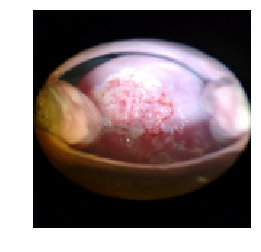

In [5]:
# ============ DOES NOT REQUIRE USER INPUT =============
simple_network.test_loading(batch_and_index=(0, 19), batch_loc=(data_folder+training_subfolder))

### Overfit the network on a single batch

To choose good parameters for training, it helps to first try and overfit the network on a batch. This will also help us check if everything is working correctly.

Each time we train we specify:

 - `epochs` is the number of epochs we train for.
 - `load_saved_model` is used for loading a saved model. It is the full path to the saved model, including epoch number, e.g. `./TensorFlow_data/trained_models/mysavedmodel-20`. If we do not want to load a model, we set `load_saved_model=""`.
 - `training_batches` is a list speciying the set of batches we use for training, i.e. each element of `training_batches` is an integer.
 - `leftright` is a boolean specifying whether we also train on images that have bee flipped left-to-right.
 - `updown` is a boolean specifying whether we also train on images that have bee flipped upside-down.
 - `save_model` is a boolean specifying whether we should save our trained model as we train. The ConvNet saves the model every ten epochs, as well as the final epoch.
 - `model_destination_folder` is the folder in which we want to save our trained model. If we are loading a saved model and further training it, this variable can be set to `model_destination_folder=""`, which will save the further trained models into the same folder as `load_saved_model`. 
 - `printout` is a boolean which sets whether we want printouts with loss and accuracy as we train.
 - We set the learning rate, dropout rate and model name for this training run.

In [6]:
# ===================== USER INPUT =====================
epochs = 35
load_saved_model = ""
training_batches = range(1, totnumbatches)
leftright = True
updown = True
save_model = True
model_destination_folder = "./TensorFlow_data/verylargemodel"
printout = True
#simple_network.learning_rate = 0.001
#simple_network.keep_prob = 0.5
simple_network.model_name = "lenet_3x3"
# ======================================================

Define a function which performs the training according to the parameters we have just specified.

In [7]:
# ============ DOES NOT REQUIRE USER INPUT =============
# These modules will be useful later
from modules.visualization import plot_accuracy_trainloss_valloss
from os.path import isfile
import numpy as np

def training_round(accuracies, train_losses, val_losses):
    """
    Performs the neural networks training according to the specifications set by the global variables.
    Takes three lists:
        accuracies: list of accuracy values, for each epoch of previously-done training
        train_losses: list of training-set losses for each epoch of previous training
        val_losses: list of validation-set losses for each epoch of previous traning.
    Returns:
        Updated lists of accuracies, train_losses, val_losses, after having performed an additional set 
        of epochs of training.
    """
    #Work out whether we specify the validation set using a batch number or a manually set array
    try:
        global validation_batch
        validation_inputarray = []
        validation_labels = []
    except:
        validation_batch = 0
        validation_inputarray = validation_inputarray
        validation_labels = validation_labels
    
    # Perform the training
    (accuracy_list,
    training_losses,
    validation_losses) = simple_network.train(epochs=epochs,
                                              load_saved_model=load_saved_model,
                                              training_batches=training_batches,
                                              leftright=leftright, updown=updown,
                                              size_of_minibatch=size_of_minibatch,
                                              validation_inputarray=validation_inputarray,
                                              validation_labels=validation_labels,
                                              validation_batchnum=validation_batch,
                                              printout=printout,
                                              save_model=save_model,
                                              model_destination_folder=model_destination_folder)
    
    return accuracies + accuracy_list,  train_losses + training_losses, val_losses + validation_losses

Now we overfit and plot the results. We may need to iterate over the above cells until we have chosen parameters that overfit.

Training...

Training Loss: 1.09636938572
Validation Loss: 1.09739518166
Accuracy (validation): 0.337690621614
Epoch  1, Batch 1 complete

Training Loss: 1.09810972214
Validation Loss: 1.09788262844
Accuracy (validation): 0.333333343267
Epoch  1, Batch 2 complete

Training Loss: 1.09408521652
Validation Loss: 1.09821081161
Accuracy (validation): 0.333333343267
Epoch  1, Batch 3 complete

Training Loss: 1.08147907257
Validation Loss: 1.09845340252
Accuracy (validation): 0.333333343267
Epoch  1, Batch 4 complete

Training Loss: 1.09302473068
Validation Loss: 1.09879243374
Accuracy (validation): 0.333333343267
Epoch  1, Batch 5 complete

Training Loss: 1.09588634968
Validation Loss: 1.09890985489
Accuracy (validation): 0.333333343267
Epoch  2, Batch 1 complete

Training Loss: 1.09682011604
Validation Loss: 1.09891653061
Accuracy (validation): 0.333333343267
Epoch  2, Batch 2 complete

Training Loss: 1.09543991089
Validation Loss: 1.0986918211
Accuracy (validation): 0.333333343267
Epoch  2

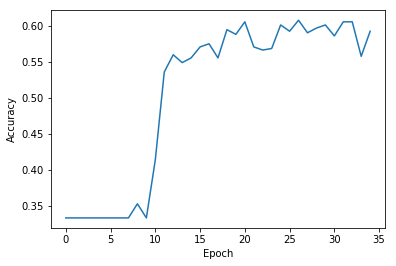

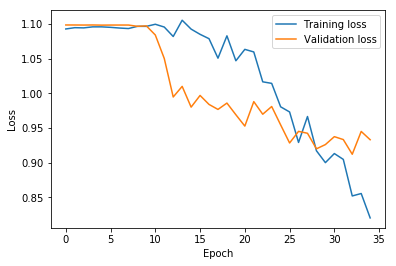

In [8]:
# ============ DOES NOT REQUIRE USER INPUT =============
if isfile(model_destination_folder + "/training_run_scores.npy") is False:
    accuracies, train_losses, val_losses = training_round([], [], [])
    np.save(model_destination_folder + "/training_run_scores.npy",
            np.array([accuracies, train_losses, val_losses]))
else:
    [accuracies, train_losses, val_losses] = np.load(model_destination_folder + "/training_run_scores.npy")

plot_accuracy_trainloss_valloss(accuracies, train_losses, val_losses)

### Track validation loss with size of training data 

In order to decide whether we need more data or more hyper-parameters, we will go through the full training for an ever-increasing number of batches. We will then plot how the validation loss improves, and in particular whether it flattens out to a plateau.

Here we should set `epochs` to the number of epochs that is just before we begin overfitting.

In [ ]:
# ===================== USER INPUT =====================
simple_network.keep_prob = 0.5
epochs = 100
model_destination_folder = "./TensorFlow_data/size_influence_models"
# ======================================================

In the cell below we perform the traninig on each subset of the data. First we train with learning rate 0.001, then we train for an equal number of epochs but with learning rate 0.0001 to fine-tune the model parameters. We store the accuracy, training loss and validation loss for each epoch of each training session in a variable called `allaccuracies`.

If we have already done this, we simply load the previsouly-done evaluations.

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
if isfile(model_destination_folder + "/allaccuracies.npy") is False:
    allaccuracies = {}
    
    tot_num_training_batches = simple_network.count_training_batches(data_folder + training_subfolder)
    for ii_max in range(1, tot_num_training_batches):
        accuracies = []
        train_losses = []
        val_losses = []
        # Set the training batches
        training_batches = range(ii_max)
        print(training_batches)
        # The model name is of the form lenet2x2_batch01234 if training batches [0, 1, 2, 3, 4]
        simple_network.model_name = "lenet2x2_batch" + "".join([str(num) for num in range(ii_max)])
        # First we don't load any model and train with learning rate 0.001
        load_saved_model = ""
        simple_network.learning_rate = 0.001
        accuracies, train_losses, val_losses = training_round(accuracies, train_losses, val_losses)
        #Now we load the model we just trained and train another set of epochs with learning rate 0.0001
        load_saved_model = model_destination_folder + "/" + simple_network.model_name + "-" + str(epochs)
        simple_network.learning_rate = 0.0001
        accuracies, train_losses, val_losses = training_round(accuracies, train_losses, val_losses)
        # We store the set of accuracies, traininf losses and validation losses for future comparison
        allaccuracies.update({simple_network.model_name: [accuracies, train_losses, val_losses]})
    np.save(model_destination_folder + "/allaccuracies.npy", allaccuracies)
else:
    allaccuracies = np.load(model_destination_folder + "/allaccuracies.npy").all()

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
from modules.neural_network import best_accuracy_trainval_loss
from modules.visualization import plot_best_scores

best_accuracy, best_train_loss, best_val_loss = best_accuracy_trainval_loss(allaccuracies)
plot_best_scores(best_accuracy, best_train_loss, best_val_loss)

From the graphs above we can see that we would benefit from more data, which we have! Our model complexity is probably sufficient for now, and our ability to capture variance in the validation set is dictated by the lack of training data.

#### Visualize training for best-performing model

The final model was the best. We will see how its accuracy, trainig loss and validation loss performed through the training and whether we began to overfit.

In [ ]:
# ============ DOES NOT REQUIRE USER INPUT =============
from modules.neural_network import sort_accuracies

best_training_run_scores = sort_accuracies(allaccuracies)[-1][1]

plot_accuracy_trainloss_valloss(best_training_run_scores[0],
                                best_training_run_scores[1],
                                best_training_run_scores[2])

From the above we see that we have a decent model which did not overfit.

# Make predictions on test set

We will now take our best trained model and make a predictions on the test set. The prediction needs to be in a format comptatible with Kaggle's [guidelines](https://www.kaggle.com/c/intel-mobileodt-cervical-cancer-screening#evaluation).

The predictions are made by running the data through the neural network and applying a softmax functions to the logits.

 - `load_saved_model` is the full path (including batch number) to the model to be used when making predictions.
 - `load_test_set` is the full path to the numpy data file which contains the test-set data.
 - Alternatively, the test set can be specified with the variable `test_set`.

In [8]:
# ===================== USER INPUT =====================
load_saved_model = "./TensorFlow_data/largermodel/lenet_3x2-30"
load_test_set = data_folder + testing_subfolder + "/testing_images.npy"
test_set = []
# ======================================================

Now we compute the probabilities for the test set.

In [9]:
# ============ DOES NOT REQUIRE USER INPUT =============
probabilities = simple_network.test(load_saved_model=load_saved_model,
                                    load_test_set=load_test_set, test_set=test_set)

### Check predictions

Plot a small subset of the test set and the generated predictions to get a feel for the quality of the predicted probabilities.

In [10]:
# ===================== USER INPUT =====================
num_images_to_check = 12
# ======================================================

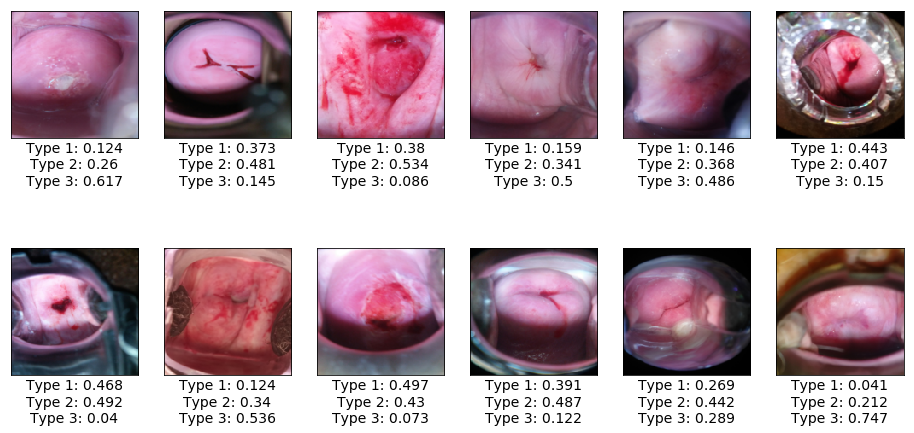

In [11]:
# ============ DOES NOT REQUIRE USER INPUT =============
from modules.visualization import display_image_probabilities

if len(test_set) == 0 and test_set == []:
    test_set = np.load(load_test_set)

np.random.seed(22)
indices_to_check = np.random.choice(range(len(test_set)), size=num_images_to_check)
fig, axes = display_image_probabilities(test_set[indices_to_check],
                                        probabilities[indices_to_check],
                                        data_folder + testing_subfolder)
fig

## Save prediction and make submission file

We are now ready to save the probabilities and make a submission to Kaggle.

 - `submission_folder` is the folder in which we place our submissions.

In [12]:
# ===================== USER INPUT =====================
submission_folder = "./submissions"
# ======================================================

Submissions are made into the above folder as csv files, with name `submissions` followed by the date and time of the file creating, i.e. `submissions_yyyy-mm-dd_hh-mm.csv`. For example, a submission file made on 30 April 2017 at 16:40 is saved as `submissions_2017-04-30_16-40.csv`.

In [13]:
# ============ DOES NOT REQUIRE USER INPUT =============
from modules.path_munging import submission

saved_path = submission(probabilities, data_folder + testing_subfolder, submission_folder)
print("Saved submission results to: " + saved_path)

Saved submission results to: ./submissions/submissions_2017-05-04_10-16.csv
